<a href="https://colab.research.google.com/github/enessoztrk/Sales_of_Products/blob/master/Bank_Credit_Analysis_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bank Credit Analysis - Classification


## Business Problem

Danışmanlık müşterilerimizden bir banka, bankanın müşterilerinden kredi başvurusunda bulunanların kredi alıp almayacağı konusunda sonuç üretecek bir makine öğrenimi modeli talep etti.
*   Data Quality 
*   Descriptive Statistics
*   Modelling
*   Evaluation





### Libraries

In [2143]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, accuracy_score, auc, roc_curve

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# 1. Data Quality


Müşteriler hakkında bilgi içeren veri setidir ve bilgilerden faydalı içgörüler elde etmek ve yeni bir müşterinin bir kredi teklifini kabul edip etmeyeceğini tahmin etmek için çalışacağız.

1 - **age**: Müşterinin yaşı


2 - **job**: müşteri mesleğidir(kategorik)

*   admin
*   blue-collar
*   entrepreneur
*   housemaid
*   management
*   self-employed
*   retired
*   unemployed
*   unknown
*   services
*   student
*   technician

3 - **marital**: medeni durum(kategorik)

*   married
*   single
*   divorced

Not: '**divorced**', boşanmış veya dul anlamına gelir





4 - **education**: eğitim durumu(kategorik)



*   primary
*   secondary
*   tertiary
*   unknown



5 - **balance**: banka bakiyesi



6- **housing**: Konut kredisi var mı? (kategorik: 'no','yes','unknown')



7 - **campaign**: bu kampanya sırasında ve bu müşteri için gerçekleştirilen iletişim sayısı (sayısal)

8 - **duration**: saniye cinsinden temas süresi (sayısal)

9 - **approval**: müşteri kredi aldı mı? (binary: 'yes', 'no')





In [2144]:
def load():
    df = pd.read_csv('/content/Credit.csv')
    return df

df = load()

In [2145]:
# Overview

def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(5))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

check_df(df)

##################### Shape #####################
(4521, 9)
##################### Types #####################
age          float64
job           object
marital       object
education     object
balance        int64
housing       object
duration     float64
campaign       int64
approval      object
dtype: object
##################### Head #####################
     age          job  marital  education  balance housing  duration  \
0 30.000   unemployed  married    primary     1787      no    79.000   
1 33.000     services  married  secondary     4789     yes   220.000   
2 35.000   management   single   tertiary     1350     yes   185.000   
3 30.000   management  married   tertiary     1476     yes   199.000   
4 59.000  blue-collar  married  secondary        0     yes   226.000   

   campaign approval  
0         1       no  
1         1       no  
2         1       no  
3         4       no  
4         1       no  
##################### NA #####################
age          2
job  

In [2146]:
# Capture of Numerical and Category Variables 

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

        Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
        Note: Categorical variables include categorical variables with numeric appearance.

        Parameters
        ------
            dataframe: dataframe
                    Dataframe to get variable names
            cat_th: int, optional
                    class threshold for numeric but categorical variables
            car_th: int, optinal
                    class threshold for categorical but cardinal variables

        Returns
        ------
            cat_cols: list
                    Categorical variable list
            num_cols: list
                    Numeric variable list
            cat_but_car: list
                    List of cardinal variables with categorical view

        Examples
        ------
            import seaborn as sns
            df = sns.load_dataset("iris")
            print(grab_col_names(df))


        Notes
        ------
            cat_cols + num_cols + cat_but_car = total number of variables
            num_but_cat is inside cat_cols.
            The sum of the 3 return lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

        """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"observations: {dataframe.shape[0]}")
    print(f"variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

observations: 4521
variables: 9
cat_cols: 5
num_cols: 4
cat_but_car: 0
num_but_cat: 0


In [2147]:
cat_cols

['job', 'marital', 'education', 'housing', 'approval']

In [2148]:
num_cols

['age', 'balance', 'duration', 'campaign']

## Exploring the Basics
check_df fonksiyonu çalıştırıldıktan sonra NA ve Quantiles çıkışları kontrol edildiğinde gözlemlerde eksik ve aykırı değerler olduğu bilinmektedir.

Bankalardan kredi alabilmek için minimum yaş 18 olduğu için minimum yaş değişkeninin 18 olacağı kabul edilecektir.(Birçok ülke için yaş sınırı 18 olduğu için bu varsayım yapılmıştır ancak mutlak doğruluk için ilgili departmanla iletişime geçilmesi gereken verilerin geldiği ülkeyi bilmek önemli detaydır.)

Yaş eksi bir değer olamayacağından iyileştirmeler yapılacaktır.
* Aykırı değerleri kontrol edecek miyiz? Ayrıca bazı yaş verilerinin gerçekçi olmayan bir şekilde yüksek olduğu da gözlendi (416 ve 300 gibi).

duration sütunu da incelenmeli, süre sütunu da negatif bir değer olmamalıdır.

In [2149]:
df = df[df['age'] >= 18]
df = df[70 >= df['age']]
df["age"].describe().T

count   4458.000
mean      40.742
std        9.881
min       19.000
25%       33.000
50%       39.000
75%       48.000
max       70.000
Name: age, dtype: float64

In [2150]:
df = df[df["duration"] >= 0]
df["duration"].describe().T

count       4450.000
mean        6072.192
std       359825.880
min            4.000
25%          104.000
50%          185.000
75%          327.000
max     23956498.000
Name: duration, dtype: float64

In [2151]:
# Outlier Analysis

def outlier_thresholds(dataframe, col_name, q1=0.01, q3=0.99):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [2152]:
def grab_outliers(dataframe, col_name, index=False):
    low, up = outlier_thresholds(dataframe, col_name)

    if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])
    else:
        print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

    if index:
        outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
        return outlier_index

In [2153]:
duration_index = grab_outliers(df, "duration", True)

        age         job  marital  education  balance housing     duration  \
852  36.000  management  married  secondary     -148      no  1440000.000   
880  26.000      admin.   single  secondary      255      no   457008.000   
2377 35.000  technician   single  secondary        2      no 23956498.000   

      campaign approval  
852          2       no  
880          1      yes  
2377         4       no  


In [2154]:
duration_index

Int64Index([852, 880, 2377], dtype='int64')

In [2155]:
# Outlier Check

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [2156]:
for col in num_cols:
    print(col, check_outlier(df, col))

age False
balance True
duration True
campaign True


In [2157]:
# Aykırı Değerlerin Baskılanması

# def replace_with_thresholds(dataframe, variable):
#     low_limit, up_limit = outlier_thresholds(dataframe, variable)
#     dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
#     dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [2158]:
# Delete Outlier 

def remove_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
    return df_without_outliers

Eşik aralıkları belirlendi, yukarı ve aşağı değerlerin dışında kalan gözlemler drop edildi.

In [2159]:
for col in num_cols:
     df = remove_outlier(df, col)
     
# Check
for col in num_cols:
      print(col, check_outlier(df, col))

age False
balance False
duration False
campaign False


In [2160]:
# Missing Value Analysis

def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")

    if na_name:
        return na_columns

na_cols = missing_values_table(df, True)

           n_miss  ratio
job             6  0.140
education       4  0.090
marital         3  0.070
housing         3  0.070


In [2161]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy()
    for col in na_columns:
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    na_flags = temp_df.loc[:, temp_df.columns.str.contains("_NA_")].columns
    for col in na_flags:
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                            "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")

missing_vs_target(df, "campaign", na_cols)

# tüm sayısal sütunlar için gözlemlenebilir('age', 'balance', 'duration', 'campaign')

             TARGET_MEAN  Count
job_NA_FLAG                    
0                  2.776   4437
1                  4.333      6


                 TARGET_MEAN  Count
marital_NA_FLAG                    
0                      2.778   4440
1                      1.667      3


                   TARGET_MEAN  Count
education_NA_FLAG                    
0                        2.777   4439
1                        4.000      4


                 TARGET_MEAN  Count
housing_NA_FLAG                    
0                      2.778   4440
1                      1.667      3




Eksik değerler varsa bunları medyan, ortalama veya mod ile doldurmamız gerekir veya silme de bir çözümdür.

Bu çalışmada kategorik değişkenler mod ile, sayısal değişkenler medyan ile doldurularak devam edilmiştir.

In [2162]:
def quick_missing_imp(data, num_method="median", cat_length=20, target="approval"):
    variables_with_na = [col for col in data.columns if data[col].isnull().sum() > 0]  # Variables with missing values are listed
    temp_target = data[target]
    print("# BEFORE")
    print(data[variables_with_na].isnull().sum(), "\n\n")  # Number of missing values of variables before implementation
    # fill nulls with mode if variable object and number of classes is less than or equal to cat_length
    data = data.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x, axis=0)
    # If num_method means mean, the null values of non-object type variables are filled with the mean
    if num_method == "mean":
        data = data.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
    # If num_method is median, empty values of non-object type variables are filled with the mean
    elif num_method == "median":
        data = data.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)
    data[target] = temp_target
    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(data[variables_with_na].isnull().sum(), "\n\n")

    return data

df = quick_missing_imp(df, num_method="median", cat_length=17)

# BEFORE
job          6
marital      3
education    4
housing      3
dtype: int64 


# AFTER 
 Imputation method is 'MODE' for categorical variables!
 Imputation method is 'MEDIAN' for numeric variables! 

job          0
marital      0
education    0
housing      0
dtype: int64 




# 2. Descriptive Statistics

               job  Ratio
management     962 21.652
blue-collar    941 21.179
technician     763 17.173
admin.         475 10.691
services       415  9.341
self-employed  182  4.096
retired        182  4.096
entrepreneur   165  3.714
unemployed     127  2.858
housemaid      110  2.476
student         84  1.891
unknown         37  0.833


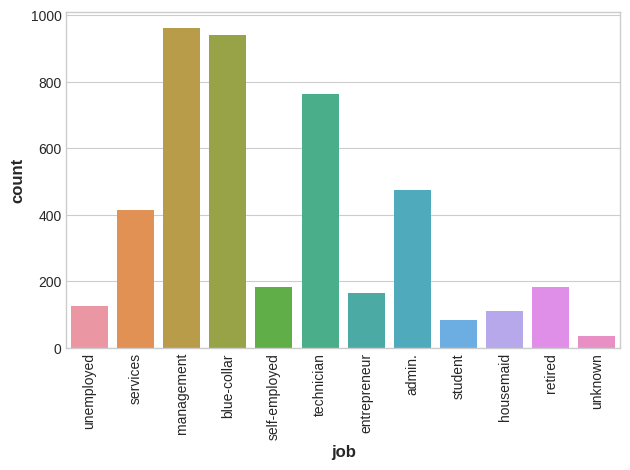

          marital  Ratio
married      2742 61.715
single       1187 26.716
divorced      514 11.569


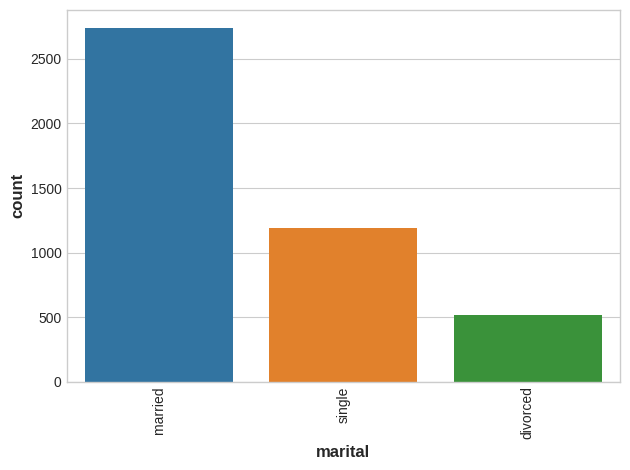

           education  Ratio
secondary       2280 51.317
tertiary        1329 29.912
primary          652 14.675
unknown          182  4.096


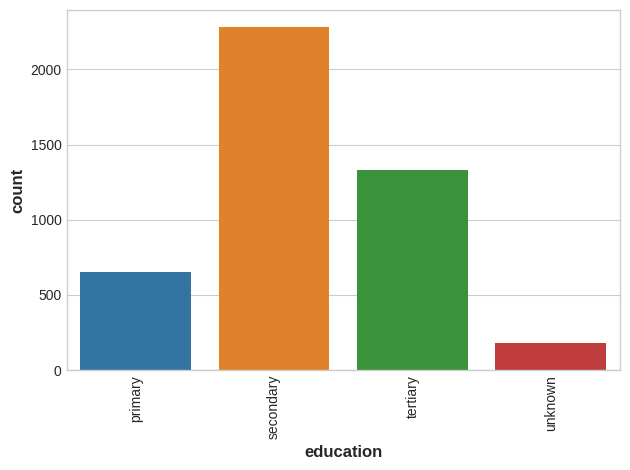

     housing  Ratio
yes     2545 57.281
no      1898 42.719


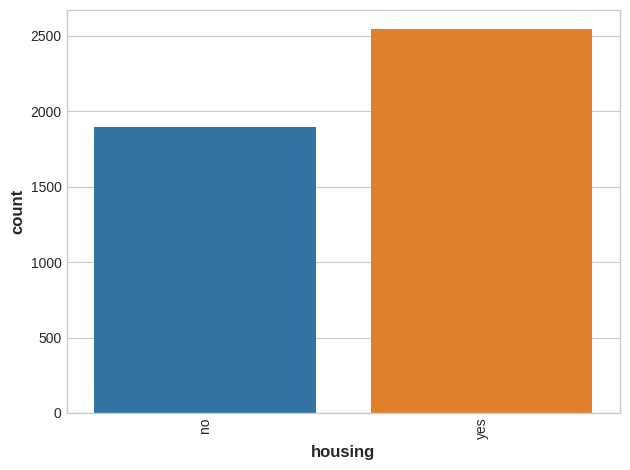

     approval  Ratio
no       3951 88.926
yes       492 11.074


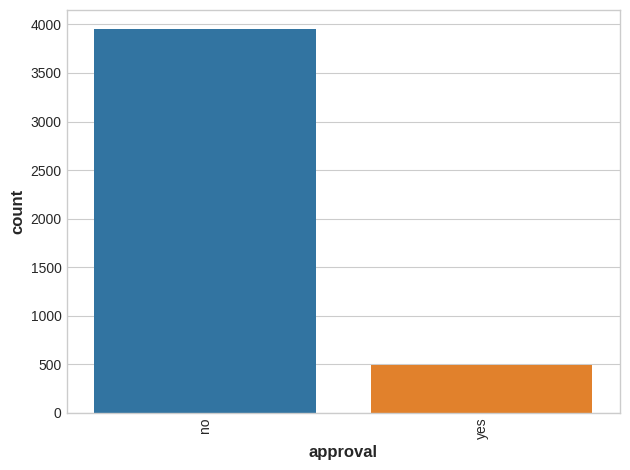

In [2163]:
# Analysis of Categorical Variables

def cat_summary(dataframe, col_name, plot=False):
     print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                         "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
     if plot:
         sns.countplot(x=dataframe[col_name], data=dataframe)
         plt.xticks(rotation=90)
         plt.show(block=True)

for col in cat_cols:
    cat_summary(df, col, True)

# Yaşın neden max 99 seçildiğini retired oranından anlaşılabilir.

Bazı kategorik sütunların bazı sınıfları çok az veri içerir, bu da sınıflar hakkında doğru tahminler yapmayı zorlaştırır. Ayrıca hedef değişkenimiz olan 'approval' sütununda bir dengesizlik durumu gözlemlendi. Böylece gelecekte hedef değişkenin tahmin edilmesini zorlaştıracaktır. Bu nedenle sütunlarda çok az veri olduğu için ilgili departmanlarla iletişime geçilerek daha fazla veri toplanmalıdır.

count   4443.000
mean      40.743
std        9.883
min       19.000
5%        27.000
10%       29.000
20%       32.000
30%       34.000
40%       36.000
50%       39.000
60%       42.000
70%       46.000
90%       55.000
95%       58.000
99%       63.000
max       70.000
Name: age, dtype: float64


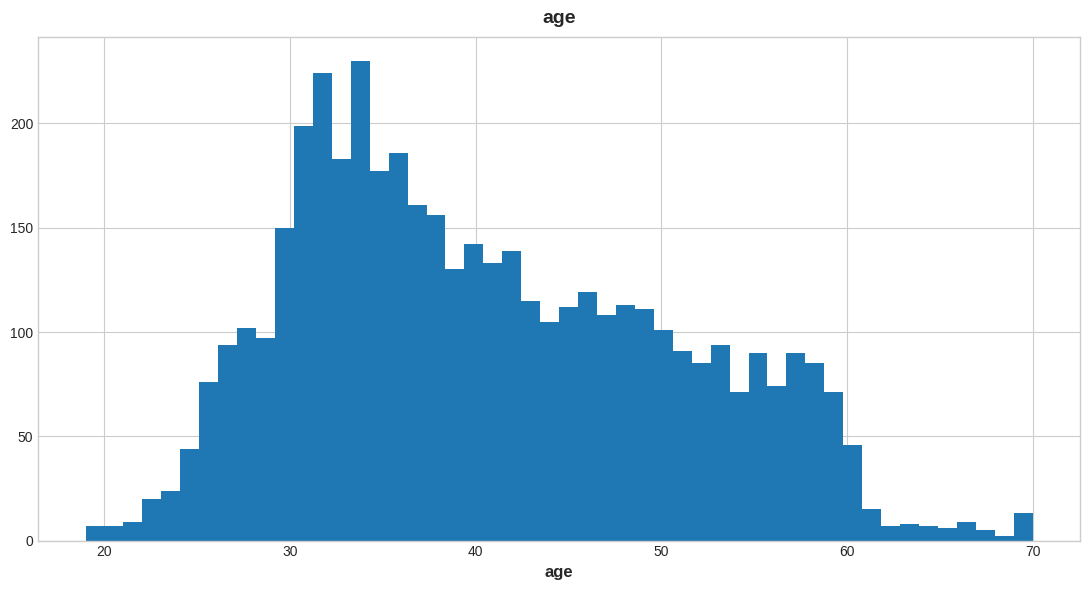

count    4443.000
mean     1382.982
std      2732.391
min     -2082.000
5%       -161.200
10%         0.000
20%        23.000
30%       126.000
40%       260.800
50%       440.000
60%       715.200
70%      1139.800
90%      3799.400
95%      5994.400
99%     13816.560
max     27733.000
Name: balance, dtype: float64


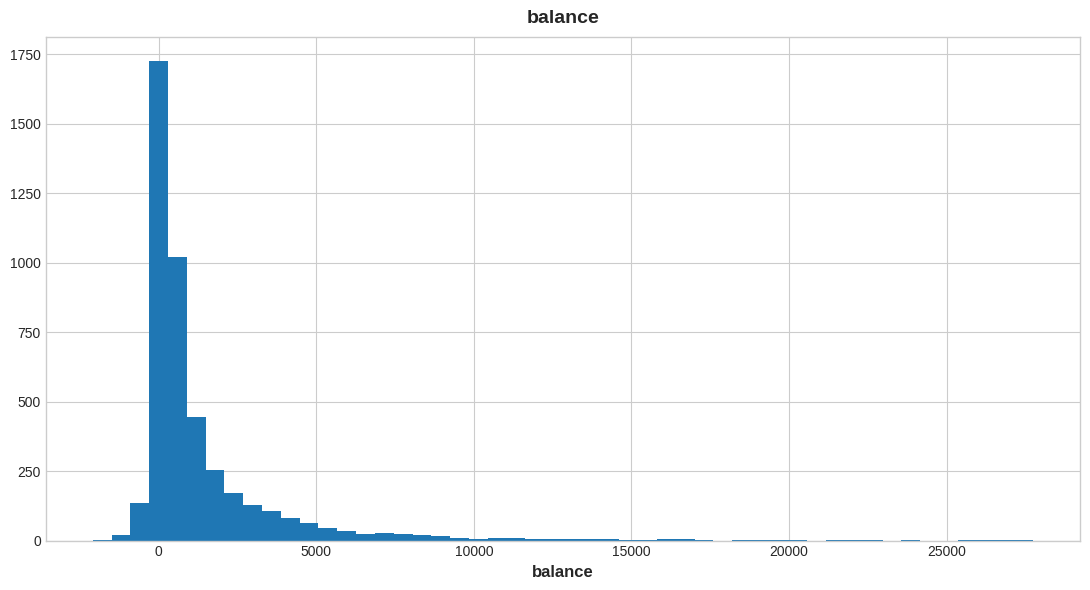

count   4443.000
mean     262.718
std      259.348
min        4.000
5%        30.000
10%       58.000
20%       88.000
30%      118.000
40%      148.000
50%      185.000
60%      225.200
70%      283.000
90%      575.600
95%      757.900
99%     1259.000
max     3025.000
Name: duration, dtype: float64


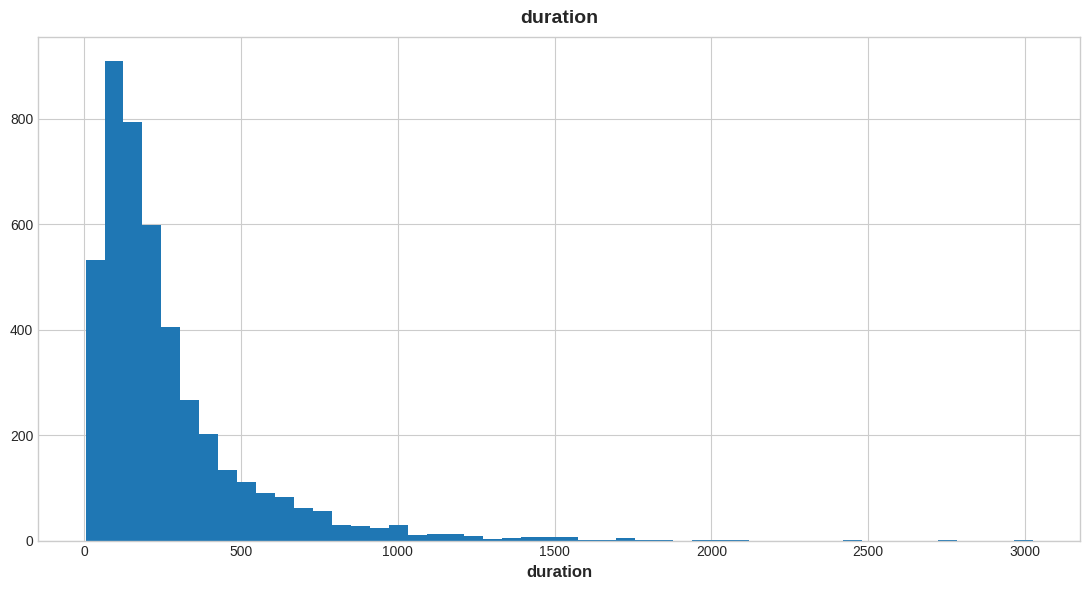

count   4443.000
mean       2.778
std        2.977
min        1.000
5%         1.000
10%        1.000
20%        1.000
30%        1.000
40%        2.000
50%        2.000
60%        2.000
70%        3.000
90%        6.000
95%        8.000
99%       16.000
max       32.000
Name: campaign, dtype: float64


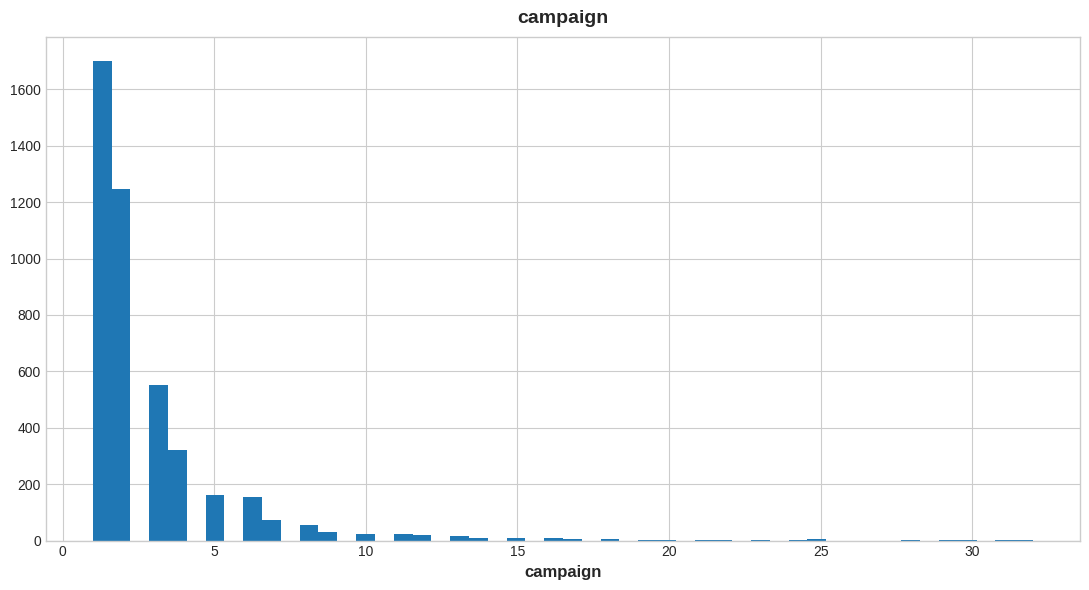

In [2164]:
# Analysis of Numerical Variables

def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)

    if plot:
        dataframe[numerical_col].hist(bins=50, figsize=(11,6))
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, True)

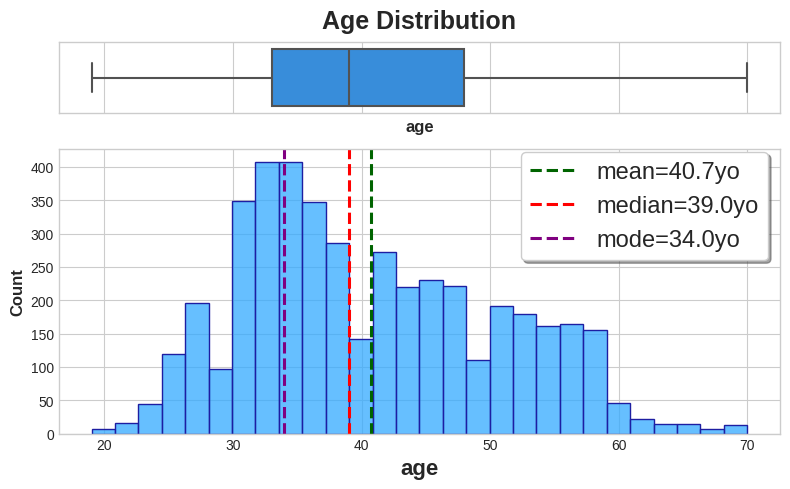

In [2165]:
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)


def num_plot(df, col, title, symb):
    fig, ax = plt.subplots(2, 1, sharex=True, figsize=(8,5),gridspec_kw={"height_ratios": (.2, .8)})
    ax[0].set_title(title,fontsize=18)
    sns.boxplot(x=col, data=df, ax=ax[0],color = "#1D8EF5")
    ax[0].set(yticks=[])
    sns.histplot(x=col, data=df, ax=ax[1],color = "#33AAFF", edgecolor="#1D1EA2")
    ax[1].set_xlabel(col, fontsize=16)
    plt.axvline(df[col].mean(), color='darkgreen', linestyle='--',linewidth=2.2, label='mean=' + str(np.round(df[col].mean(),1)) + symb)
    plt.axvline(df[col].median(), color='red', linestyle='--',linewidth=2.2, label='median='+ str(np.round(df[col].median(),1)) + symb)
    plt.axvline(df[col].mode()[0], color='purple', linestyle='--',linewidth=2.2, label='mode='+ str(np.round(df[col].mode()[0],1)) + symb)
    plt.legend(bbox_to_anchor=(1, 1.03), ncol=1, fontsize=17, fancybox=True, shadow=True, frameon=True)
    plt.tight_layout()
    plt.show()

num_plot(df, 'age', 'Age Distribution', 'yo')

The distribution of 'age' is right skewed.


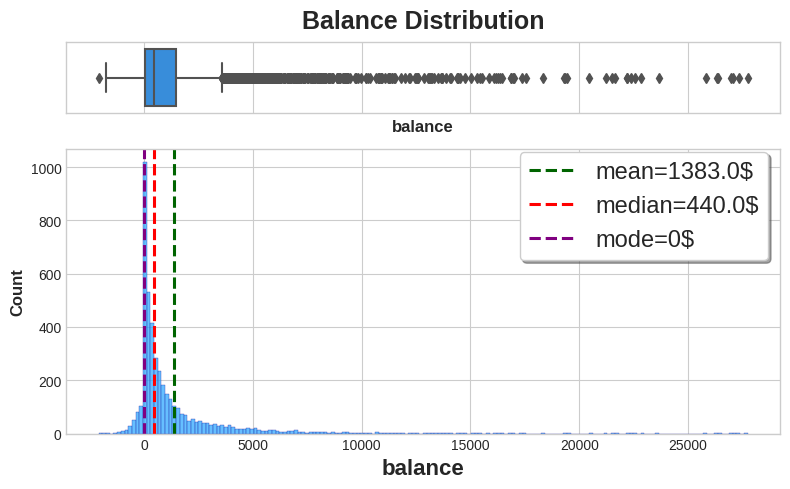

In [2166]:
num_plot(df, 'balance', 'Balance Distribution', '$')

The distribution is heavily skewed to the right, with some negative values.
 
I assumed that the balance column was negative and the person was indebted and better actions should be taken by communicating with the necessary departments.

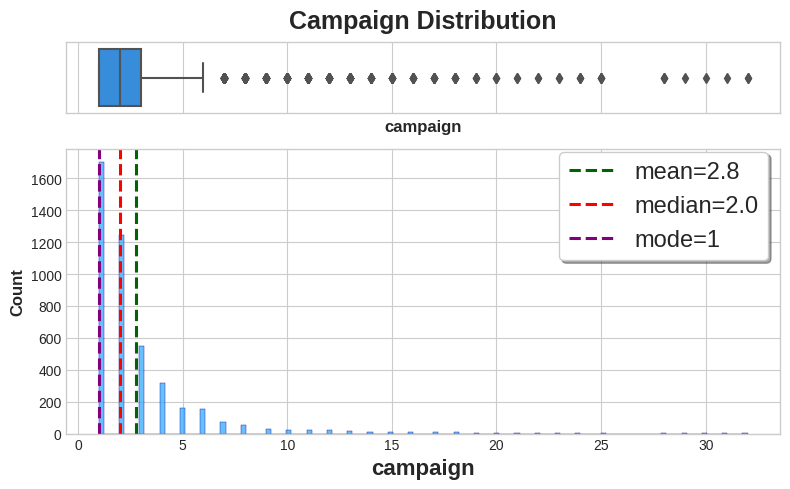

In [2167]:
num_plot(df, 'campaign', 'Campaign Distribution', '')

This variable presents a long tail distribtion, as the previous ones.

In [2168]:
# Rare Analysis

def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, "balance", cat_cols)

# ['age', 'balance', 'duration', 'campaign']

job : 12
               COUNT  RATIO  TARGET_MEAN
admin.           475  0.107     1224.741
blue-collar      941  0.212     1078.940
entrepreneur     165  0.037     1403.927
housemaid        110  0.025     2117.155
management       962  0.217     1753.766
retired          182  0.041     1828.610
self-employed    182  0.041     1418.264
services         415  0.093     1109.113
student           84  0.019     1543.821
technician       763  0.172     1335.098
unemployed       127  0.029     1099.307
unknown           37  0.008     1532.757


marital : 3
          COUNT  RATIO  TARGET_MEAN
divorced    514  0.116     1114.994
married    2742  0.617     1398.759
single     1187  0.267     1462.583


education : 4
           COUNT  RATIO  TARGET_MEAN
primary      652  0.147     1300.147
secondary   2280  0.513     1174.466
tertiary    1329  0.299     1737.749
unknown      182  0.041     1701.346


housing : 2
     COUNT  RATIO  TARGET_MEAN
no    1898  0.427     1512.171
yes   2545  0.573     1

As can be seen, there are few data from some professions. Applicants from these professions may seem low because our data is imbalanced.

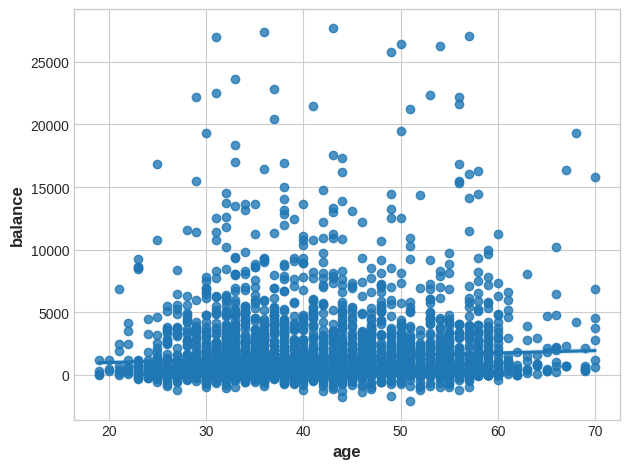

In [2169]:
sns.regplot(x='age',y='balance', data=df)
plt.show()

This plot looks messy, we will create a categorical column for 'age'.



In [2170]:
df["age_cut"] = pd.cut(df['age'], bins=[0, 35, 55, 70, float('Inf')], labels=['0-35', '35-55', '55-70', '70-100'])

**More data should be added to our dataset, but overall reviews have been done.**

**In order for all these graphs to give correct results, there should be no imbalance data.** 


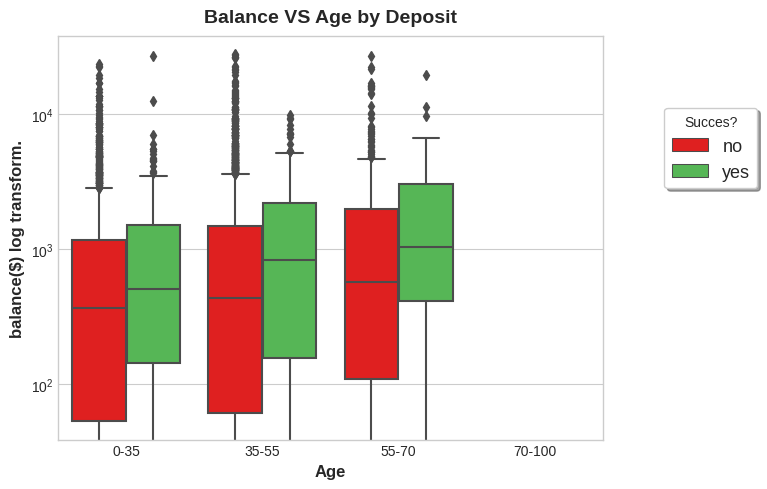

In [2171]:
palette = {'yes':'green', 'no':'red'}
palette = {'yes':'#46C646', 'no':'#FF0000'}

plt.figure(figsize=(8,5))
sns.boxplot(x='age_cut', y='balance', hue='approval', data=df, palette=palette)
plt.ylabel('balance($) log transform.')
plt.xlabel('Age')
plt.title('Balance VS Age by Deposit')
plt.yscale('log')
plt.legend(bbox_to_anchor=(1.3, 0.6), title='Succes?', loc = 'lower right', fontsize=13, fancybox=True, shadow=True, frameon=True)
plt.show()

From this plot we can see that older customers tends to have a higher bank balance and that customers who accepted the deposit tended to have a higher balance compared to the customers who refused the deposit. 

In [2172]:
df = df.drop('age_cut', axis=1)

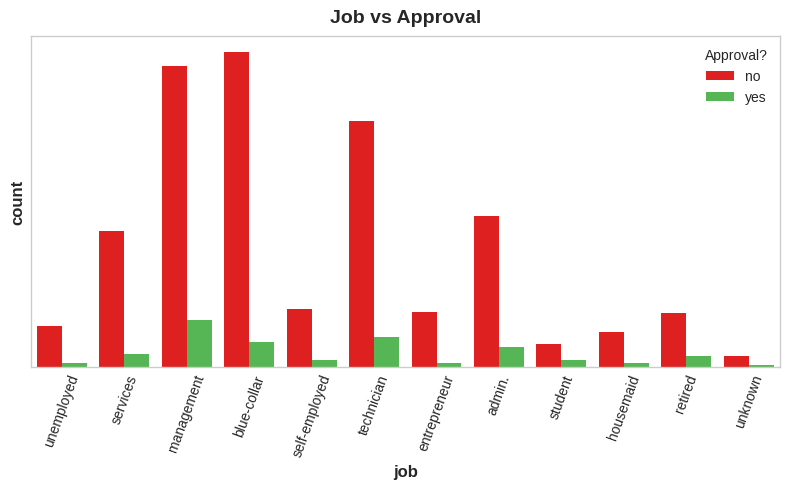

In [2173]:
# Job Vs Approval

plt.figure(figsize=(8, 5));
plt.title('Job vs Approval')
g = sns.countplot(x= 'job', hue = 'approval', data=df, palette=palette)
plt.xticks(rotation=70)
plt.yticks([])
plt.legend(title='Approval?', ncol=1, fancybox=True, shadow=True)
plt.show()

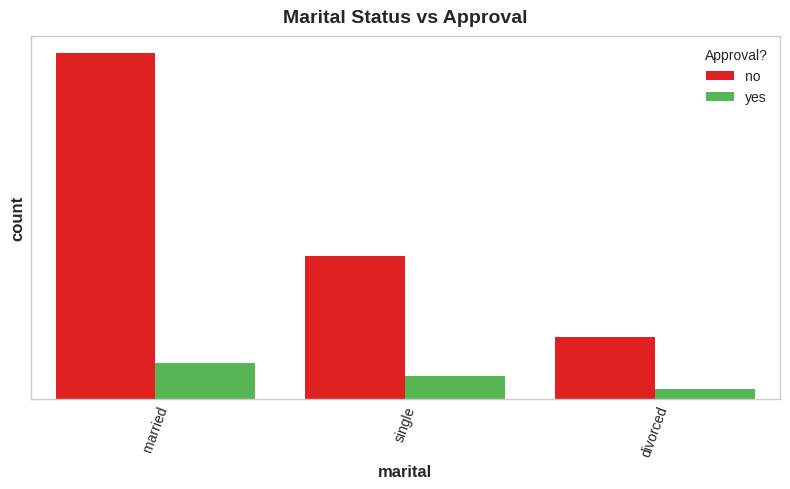

In [2174]:
# Marital Status vs Campaign Success

plt.figure(figsize=(8, 5));
plt.title('Marital Status vs Approval')
g = sns.countplot(x= 'marital', hue = 'approval', data=df, palette=palette);
plt.xticks(rotation=70)
plt.yticks([])
plt.legend(title='Approval?', ncol=1, fancybox=True, shadow=True)
plt.show()

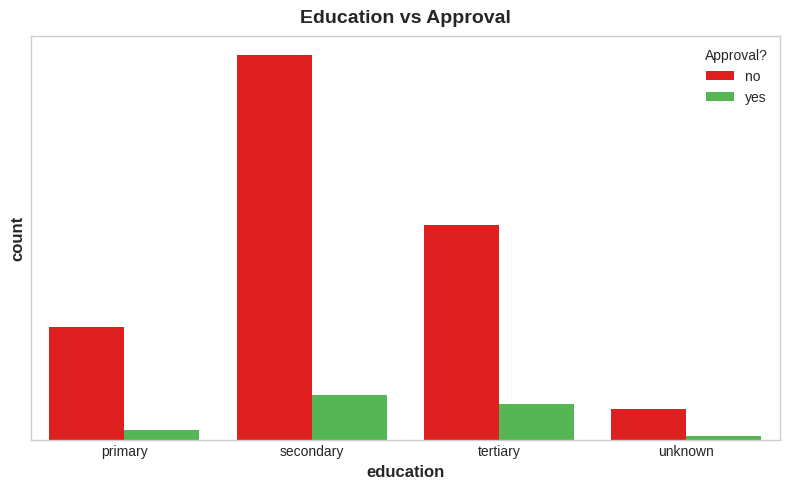

In [2175]:
plt.figure(figsize=(8, 5));
plt.title('Education vs Approval')
g = sns.countplot(x= 'education', hue = 'approval', data=df, palette=palette);
plt.legend(title='Approval?', ncol=1, fancybox=True, shadow=True)
plt.yticks([])
plt.show()

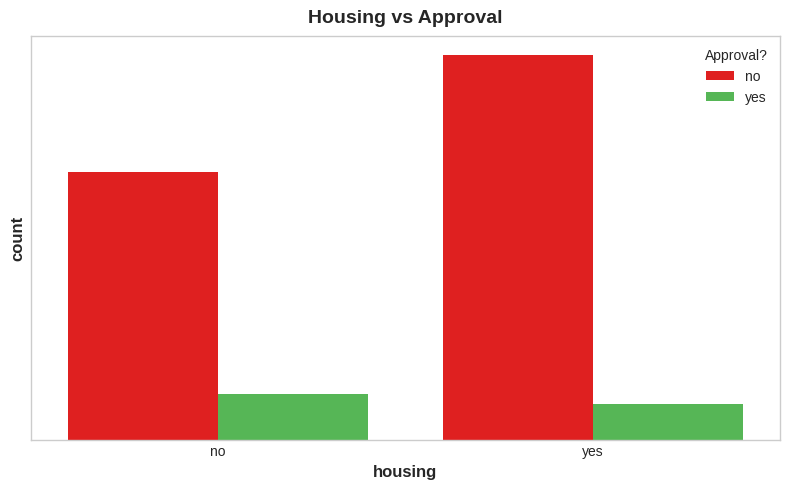

In [2176]:
plt.figure(figsize=(8, 5));
plt.title('Housing vs Approval')
g = sns.countplot(x= 'housing', hue = 'approval', data=df, palette=palette);
plt.legend(title='Approval?', ncol=1, fancybox=True, shadow=True)
plt.yticks([])
plt.show()

In [2177]:
# Analysis of Correlation

corr = df[num_cols].corr()
corr

,age,balance,duration,campaign
age,1.000,0.069,-0.018,0.000
balance,0.069,1.000,-0.018,-0.003
duration,-0.018,-0.018,1.000,-0.064
campaign,0.000,-0.003,-0.064,1.000


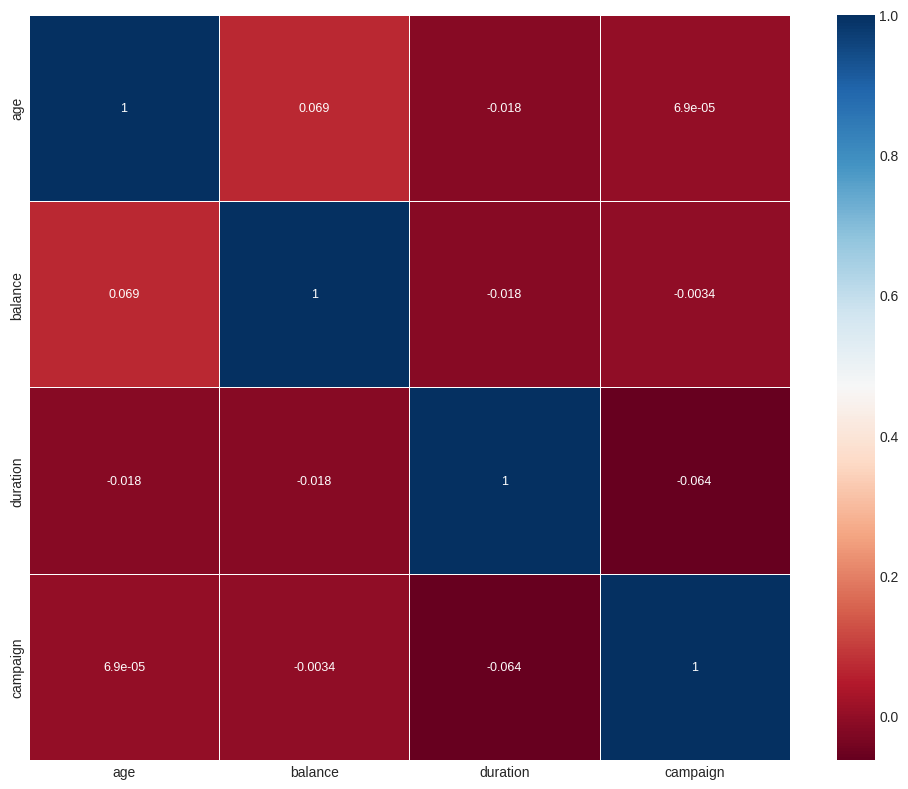

In [2178]:
def correlation_matrix(df, cols):
     fig = plt.gcf()
     fig.set_size_inches(10, 8)
     plt.xticks(fontsize=10)
     plt.yticks(fontsize=10)
     fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 9}, linecolor='w', cmap='RdBu')
     plt.show(block=True)

correlation_matrix(df, num_cols)

Although it seems that there is a positive correlation between the 'age' column and 'balance', we cannot speak and analyze clearly because our data is imbalanced.

###Summary
There are not that much insights we can gain from the descriptive dataset since most of our descriptive data is located not in the "numeric" columns but in the "categorical columns".

**Number of Job**: Blue-collar is the occupation that is more prevalent in this dataset.(It's about the same as management)

**Age by Job**: As expected, the retired are the ones who have the highest median age while student are the lowest.

**Balance by Job**: Management and Retirees are the ones who have the highest balance in their accounts.

**Marital Status by Balance**: Balance observations turned out to be lower because they had to split financial assets after their divorce.

**Housing of Balance**: Whether the potential customer has a previous home loan has a significant impact on the amount of balance he or she has.

**All these comments are for analysis only, as our data is imbalanced.**

# Modelling

First, we encode the target variable.
We note that the target column presents just two possible values: 'yes' or 'no'. Since these binary values appears in more columns, we encode all the 'yes' and 'no' in the whole dataframe with 0 and 1.

In [2179]:
# Capture of Numerical and Category Variables 

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """

        Returns the names of categorical, numeric and categorical but cardinal variables in the data set.
        Note: Categorical variables include categorical variables with numeric appearance.

        Parameters
        ------
            dataframe: dataframe
                    Dataframe to get variable names
            cat_th: int, optional
                    class threshold for numeric but categorical variables
            car_th: int, optinal
                    class threshold for categorical but cardinal variables

        Returns
        ------
            cat_cols: list
                    Categorical variable list
            num_cols: list
                    Numeric variable list
            cat_but_car: list
                    List of cardinal variables with categorical view

        Examples
        ------
            import seaborn as sns
            df = sns.load_dataset("iris")
            print(grab_col_names(df))


        Notes
        ------
            cat_cols + num_cols + cat_but_car = total number of variables
            num_but_cat is inside cat_cols.
            The sum of the 3 return lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables

        """
    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"observations: {dataframe.shape[0]}")
    print(f"variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    return cat_cols, num_cols, cat_but_car

cat_cols, num_cols, cat_but_car = grab_col_names(df)

observations: 4443
variables: 9
cat_cols: 5
num_cols: 4
cat_but_car: 0
num_but_cat: 0


In [2180]:
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)

observations: 4443
variables: 9
cat_cols: 5
num_cols: 4
cat_but_car: 0
num_but_cat: 0


In [2181]:
cat_cols

['job', 'marital', 'education', 'housing', 'approval']

In [2182]:
num_cols

['age', 'balance', 'duration', 'campaign']

In [2183]:
# Mesleklerin gelir aralıklarını belirle
income_ranges = {
    "management": "yüksek gelirli",
    "blue-collar": "orta gelirli",
    "technician": "orta gelirli",
    "admin.": "orta gelirli",
    "services": "düşük gelirli",
    "self-employed": "yüksek gelirli",
    "retired": "düşük gelirli",
    "entrepreneur": "yüksek gelirli",
    "unemployed": "düşük gelirli",
    "housemaid": "düşük gelirli",
    "student": "düşük gelirli",
    "unknown": "düşük gelirli"
}
df["income_range"] = df["job"].map(income_ranges)

# Yaşa göre grupla
df['age_group'] = pd.cut(df['age'], bins=[0, 30, 40, 50, 60, 100], labels=['18-30', '30-40', '40-50', '50-60', '60+'])

# Bakiyeye göre grupla
df['balance_group'] = pd.cut(df['balance'], bins=[-3000, 0, 100, 1000, 10000, np.inf], labels=['borçlu', '0-100', '100-1k', '1k-10k', '10k+'])

# Aramaların sayısına göre grupla
df["campaign_group"] = pd.cut(df["campaign"], bins=[0, 2, 5, 10, 20, 32], labels=['1-2', '3-5', '6-10', '11-20', '20+'], include_lowest=True)

# Arama süresine göre grupla
df['duration_group'] = pd.cut(df['duration'], bins=[0, 30, 60, 300, np.inf], labels=['kısa', 'orta', 'uzun', 'çok uzun'])

cat_cols = ['job', 'marital', 'education', 'housing', 'approval', 'income_range', 'campaign_group', 'duration_group', 'age_group', 'balance_group']

In [2184]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)

In [2185]:
# MinMaxScaler is used because negative values are also available.
scaler = MinMaxScaler()
df["balance"] = scaler.fit_transform(df[['balance']])


standart_scaler = StandardScaler()
df["age"] = standart_scaler.fit_transform(df[['age']])

df.dropna(inplace=True)

In [2186]:
# Split data into features and target 

X = df.drop('approval_yes', axis=1)
y = df['approval_yes']

To monitor accuracy in the validation set and avoid overfitting, we split the trainset into a new train and validation set.

In [2187]:
# Split the data into training and test sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [2188]:
# Apply the SMOTE algorithm to balance the data
# n_job: Uses the entire processor of the running environment. 

smote = SMOTE(n_jobs=-1)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

# {'early_stopping_rounds': 5, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'reg_alpha': 0.1}

In [2189]:
!pip install lazypredict

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2190]:
from lazypredict.Supervised import LazyClassifier
clf = LazyClassifier(predictions = True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)
models

100%|██████████| 29/29 [00:18<00:00,  1.60it/s]


,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
NearestCentroid,0.751,0.721,0.721,0.791,0.059
BernoulliNB,0.799,0.691,0.691,0.823,0.026
DecisionTreeClassifier,0.842,0.657,0.657,0.848,0.050
LinearDiscriminantAnalysis,0.892,0.643,0.643,0.879,0.080
LGBMClassifier,0.883,0.609,0.609,0.866,1.499
XGBClassifier,0.879,0.600,0.600,0.861,8.659
BaggingClassifier,0.884,0.599,0.599,0.864,0.136
LogisticRegression,0.895,0.594,0.594,0.869,0.109
CalibratedClassifierCV,0.897,0.591,0.591,0.869,1.643


In [2191]:
# Create the XGBoost model with the specified hyperparameters
from xgboost import XGBClassifier

model = XGBClassifier()

In [2192]:
def duplicate_columns(frame):
    groups = frame.columns.to_series().groupby(frame.dtypes).groups
    dups = []

    for t, v in groups.items():

        cs = frame[v].columns
        vs = frame[v]
        lcs = len(cs)

        for i in range(lcs):
            iv = vs.iloc[:,i].tolist()
            for j in range(i+1, lcs):
                jv = vs.iloc[:,j].tolist()
                if iv == jv:
                    dups.append(cs[i])
                    break

    return dups

duplicated_cols = duplicate_columns(X_resampled)
X_resampled = X_resampled.loc[:,~X_resampled.columns.duplicated()]
X_test = X_test.loc[:,~X_test.columns.duplicated()]

In [2193]:
# Train the model on the training set
model.fit(X_resampled, y_resampled)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Specificity: 0.9439847231063018


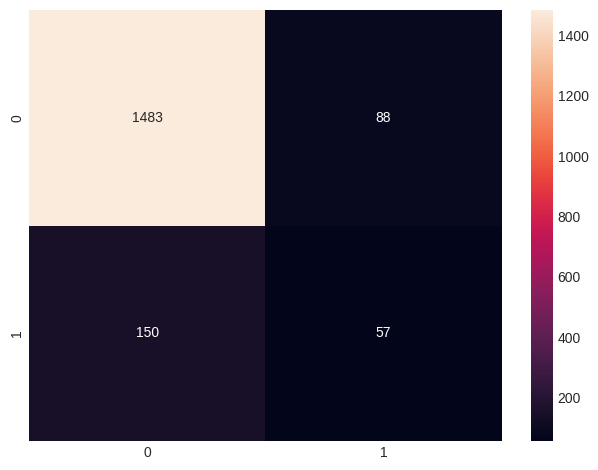

In [2194]:
# Evaluate the model on the test set

y_pred = model.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True, fmt='g');

print("Specificity:",specificity)

In [2195]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.93      1571
           1       0.39      0.28      0.32       207

    accuracy                           0.87      1778
   macro avg       0.65      0.61      0.62      1778
weighted avg       0.85      0.87      0.86      1778



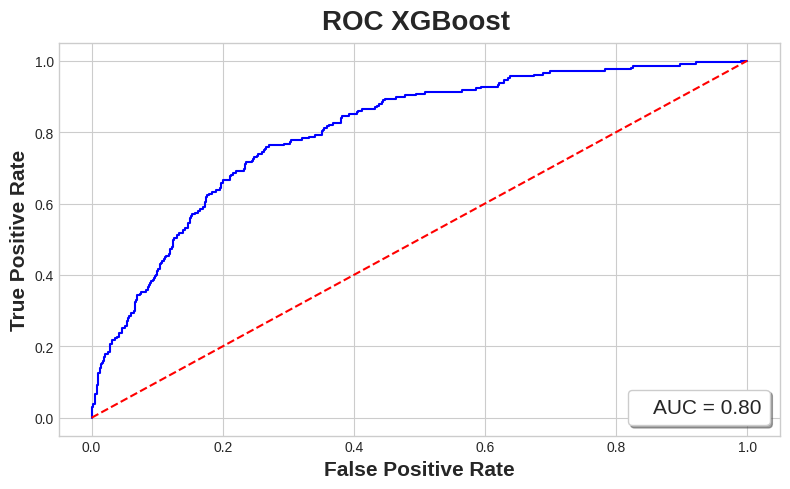

In [2196]:
plt.figure(figsize = (8, 5))

probs = model.predict_proba(X_test)
preds = probs[:,1]
fprxgb, tprxgb, _ = roc_curve(y_test, preds)
roc_aucxgb = auc(fprxgb, tprxgb)

plt.plot(fprxgb, tprxgb, 'b', label = 'AUC = %0.2f' % roc_aucxgb)
plt.plot([0, 1], [0, 1],'r--')
plt.title('ROC XGBoost ',fontsize=20)
plt.ylabel('True Positive Rate',fontsize=15)
plt.xlabel('False Positive Rate',fontsize=15)
plt.legend(loc = 'lower right', fontsize=15, fancybox=True, shadow=True, frameon=True,handlelength=0)
plt.show()